In [1]:
from althtml.compiler import AlthtmlCompiler
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [2]:
%%writefile temp.txt
<table border="1" class="dataframe">
            <thead>
                <tr style="text-align: right;">
                <th></th>
                <th>A</th>
                <th>N</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                <th>0</th>
                <td>A</td>
                <td>1</td>
                </tr>
                <tr>
                <th>1</th>
                <td>B</td>
                <td>2</td>
                </tr>
                <tr>
                <th>2</th>
                <td>C</td>
                <td>3</td>
                </tr>
            </tbody>
        </table>

Overwriting temp.txt


In [3]:
%%writefile temp.aml
:macro !card
    a @2
        div lg:w-64 md:w-64 sm:w-64 max-w-96 card shadow-xl bg-base-100 h-64 w-64
            div card-body text-sm text-left text-base-content
            h1 card-title text-md h-[45%] | @0
            div line-clamp-5 
                p | @1
:macro table
    raw
        <table border="1" class="dataframe">
            <thead>
                <tr style="text-align: right;">
                <th></th>
                <th>A</th>
                <th>N</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                <th>0</th>
                <td>A</td>
                <td>1</td>
                </tr>
                <tr>
                <th>1</th>
                <td>B</td>
                <td>2</td>
                </tr>
                <tr>
                <th>2</th>
                <td>C</td>
                <td>3</td>
                </tr>
            </tbody>
        </table>

Overwriting temp.aml


In [4]:
import pandas as pd
df = pd.DataFrame()
df['A'] = 'A B C'.split(' ')
df['N'] = [1, 2, 3]

In [5]:
# print(df.to_html())

In [ ]:
%%writefile temp2.aml
html
    body
        div
            rawf temp.txt
            | Hello World!
            rawf data/temp.svg

Overwriting temp2.aml


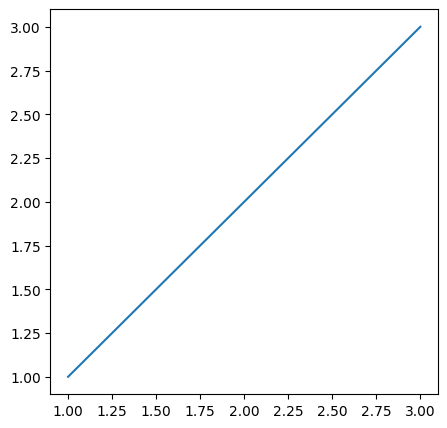

In [14]:
fig = plt.figure(figsize=(5, 5))
plt.plot([1, 2, 3], [1, 2, 3])
plt.savefig('temp.svg')

In [15]:
compiler = AlthtmlCompiler()
with open('temp.aml', 'r') as f:
    aml = f.read()
    compiler.compile(aml)
with open('temp2.aml', 'r') as f:
    aml2 = f.read()
    out = compiler.compile(aml2)
with open('temp.html', 'w') as f:
    f.write(out)
HTML(out)

,A,N
0,A,1
1,B,2
2,C,3


In [16]:
print(out)

<html>
  <body>
    <div>
      <table border="1" class="dataframe">
                  <thead>
                      <tr style="text-align: right;">
                      <th></th>
                      <th>A</th>
                      <th>N</th>
                      </tr>
                  </thead>
                  <tbody>
                      <tr>
                      <th>0</th>
                      <td>A</td>
                      <td>1</td>
                      </tr>
                      <tr>
                      <th>1</th>
                      <td>B</td>
                      <td>2</td>
                      </tr>
                      <tr>
                      <th>2</th>
                      <td>C</td>
                      <td>3</td>
                      </tr>
                  </tbody>
              </table>
      Hello World!
      <?xml version="1.0" encoding="utf-8" standalone="no"?>
      <!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
        "http://www.w3.org/

In [16]:
import watchdog

althtml extends a compile function. I would like to use watchdog to poll a config such as this one, whenever a file changes I would like to recompile the appropriate althtml and alth files.

In [17]:
%%writefile config.yaml
headers :
    - ./headers/*.alth
write :
    -
        src : ./temp.althtml
        dst : ./index.html
    -
        src : ./temp2.althtml
        dst : ./index2.html

Overwriting config.yaml


In [18]:
import yaml
from pathlib import Path

In [19]:
cfg =  yaml.safe_load(open("config.yaml", "r"))
base_path = Path('.')
no_write_paths = {header for header_str in cfg['headers'] for header in base_path.glob(header_str)}
write_pairs = {Path(to_write['src']) : Path(to_write['dst']) for to_write in cfg['write']}


In [20]:
no_write_paths

{WindowsPath('headers/ex.alth')}

In [21]:
cfg['write']

[{'src': './temp.althtml', 'dst': './index.html'},
 {'src': './temp2.althtml', 'dst': './index2.html'}]

In [22]:
base_path = Path('.')
list(base_path.glob(cfg['headers'][0]))

[WindowsPath('headers/ex.alth')]

In [23]:
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
import logging

In [24]:
write_pairs

{WindowsPath('temp.althtml'): WindowsPath('index.html'),
 WindowsPath('temp2.althtml'): WindowsPath('index2.html')}

In [25]:
compiler = AlthtmlCompiler()
header_files = no_write_paths


In [26]:
def trigger_recompile(write_pairs, header_files, compiler):
    for h in header_files:
        compiler.compile(open(h, "r").read())
    for (k, v) in write_pairs.items():
        with open(v, "w+") as f:
            f.write(compiler.compile(open(k, "r").read()))

In [27]:
class ChangeHandler(FileSystemEventHandler):
    def __init__(self, files_to_watch, write_pairs = None, header_files = None):
        self.files_to_watch = [x.resolve() for x in files_to_watch] # Set of absolute paths (headers + sources)
        self.write_pairs = write_pairs       # Dict {abs_src: abs_dst}
        self.header_files = header_files     # Set of absolute paths (headers)
        self.compiler = AlthtmlCompiler()
        print("Handler initialized. Monitoring for changes...")

    def on_modified(self, event):
        if event.is_directory:
            return

        # Resolve path and check if it's one we care about
        src_path_abs = Path(event.src_path).resolve()
        if src_path_abs in self.files_to_watch:
            # Use relative path for cleaner logging
            try:
                rel_path = src_path_abs.relative_to(base_path)
            except ValueError:
                 rel_path = src_path_abs # If somehow not relative to base path

            print(f"\nDetected modification in: {rel_path}")
            # Pass the necessary path collections to the trigger function
            trigger_recompile(self.write_pairs, self.header_files, self.compiler)
        # else: file modified is not in our watch list, ignore.

    # on_created, on_deleted can be added similarly if needed

In [28]:
def run_watcher(no_write_paths, write_pairs):
    """Sets up and runs the watchdog observer."""
    files_to_watch = set(write_pairs.keys())
    dirs_to_watch = {p.parent for p in files_to_watch | no_write_paths}
    
    if not dirs_to_watch:
         print("Error: No valid directories provided to watch.")
         return
    if not files_to_watch:
         print("Warning: No specific files provided to monitor within directories.")
         # Decide if you want to proceed or exit if files_to_watch is empty
    
    
    
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    event_handler = ChangeHandler(files_to_watch | no_write_paths, write_pairs=write_pairs, header_files=no_write_paths)
    observer = Observer()

    scheduled_count = 0
    for dir_path in dirs_to_watch:
        if not isinstance(dir_path, Path):
             print(f"Error: Item in dirs_to_watch is not a Path object: {dir_path}")
             continue
        if not dir_path.is_dir():
             print(f"Warning: Directory '{dir_path}' does not exist. Cannot watch.")
             continue

        # Schedule monitoring for the directory.
        # recursive=False means watchdog only looks for events directly
        # within this directory, not subdirectories.
        observer.schedule(event_handler, str(dir_path), recursive=False)
        scheduled_count += 1
        print(f"Scheduled watcher for directory: {dir_path}")

    if scheduled_count == 0:
         print("Error: No watchers were successfully scheduled. Exiting.")
         return

    observer.start()
    print(f"\nWatching for file changes in {scheduled_count} director{'y' if scheduled_count == 1 else 'ies'}. Press Ctrl+C to stop.")

    try:
        while observer.is_alive():
            observer.join(timeout=1) # Wait for observer thread, check status periodically
    except KeyboardInterrupt:
        print("\nStopping watcher (Ctrl+C pressed)...")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
    finally:
        if observer.is_alive():
            observer.stop()
            print("Observer stop signal sent.")
        # Wait for the observer thread to fully finish shutting down
        observer.join()
        print("Watcher stopped completely.")

In [29]:
run_watcher(no_write_paths, write_pairs)

Handler initialized. Monitoring for changes...
Scheduled watcher for directory: headers
Scheduled watcher for directory: .

Watching for file changes in 2 directories. Press Ctrl+C to stop.

Stopping watcher (Ctrl+C pressed)...
Watcher stopped completely.


An unexpected error occurred: list index out of range
